# Single cell analysis using scanpy

### Importing libraries

In [1]:
import numpy as np
import os
import scanpy as sc
from scipy.sparse import csr_matrix

In [2]:
## Setting random seed
np.random.seed(12345)

### Reading raw samples

In [3]:
path_to_raw_files = "/home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/"
files = os.listdir(path_to_raw_files)
files

['HUVEC_TGF_DAY7_10',
 'HUVEC_PLKO-empty_5',
 'HUVEC_pRRL-empty_3',
 'HUVEC_CTL_DAY7_11',
 'HUVEC_TGF_DAY7_12',
 'HUVEC_SNAIOE_8',
 'HUVEC_shERG_6',
 'HUVEC_shERG_2',
 'HUVEC_CTL_DAY7_9',
 'HUVEC_PLKO-empty_1',
 'HUVEC_pRRL-empty_7',
 'HUVEC_SNAIOE_4']

In [4]:
import scanpy as sc
import os

adata_list = []

files = [f for f in os.listdir(path_to_raw_files) 
         if os.path.isdir(os.path.join(path_to_raw_files, f))]

for file in files:
    file_path = os.path.join(path_to_raw_files, file)

    print("Reading:", file_path)

    # read raw 10X matrix
    adata = sc.read_10x_mtx(file_path, var_names="gene_symbols", cache=True)

    # annotate project
    adata.obs['sample'] = file
    adata.obs_names = [f"{file}_{cell}" for cell in adata.obs_names]

    # filter out empty droplets and very rare genes
    sc.pp.filter_cells(adata, min_counts=100)   # keep barcodes with ≥100 UMIs
    sc.pp.filter_genes(adata, min_cells=3)      # keep genes seen in ≥3 cells

    print(f"{file}: {adata.shape} after filtering")

    adata_list.append(adata)

Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10: (9957, 21050) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_PLKO-empty_5
HUVEC_PLKO-empty_5: (6975, 17528) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_pRRL-empty_3
HUVEC_pRRL-empty_3: (9279, 19042) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_CTL_DAY7_11
HUVEC_CTL_DAY7_11: (18806, 21824) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_TGF_DAY7_12
HUVEC_TGF_DAY7_12: (10809, 20649) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_SNAIOE_8
HUVEC_SNAIOE_8: (9179, 19122) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_shERG_6
HUVEC_shERG_6: (10297, 18841) after filtering
Reading: /home/mhassan/R_Projects/Multiome/Cantelmo/GSE237895_RAW/HUVEC_shER

In [5]:
# Check summary
print("Final datasets:")
for ad in adata_list:
    print(ad.obs['sample'][0], ad.shape)

Final datasets:
HUVEC_TGF_DAY7_10 (9957, 21050)
HUVEC_PLKO-empty_5 (6975, 17528)
HUVEC_pRRL-empty_3 (9279, 19042)
HUVEC_CTL_DAY7_11 (18806, 21824)
HUVEC_TGF_DAY7_12 (10809, 20649)
HUVEC_SNAIOE_8 (9179, 19122)
HUVEC_shERG_6 (10297, 18841)
HUVEC_shERG_2 (13173, 19339)
HUVEC_CTL_DAY7_9 (8951, 20997)
HUVEC_PLKO-empty_1 (25255, 21552)
HUVEC_pRRL-empty_7 (11725, 18759)
HUVEC_SNAIOE_4 (9250, 19781)


/tmp/ipykernel_1125511/2455908061.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ad.obs['sample'][0], ad.shape)


In [21]:
import anndata as ad

adata = ad.concat(
    adata_list,
    join="outer",           # keep all genes
    label="sample",         # name of the new obs column indicating the original object
    keys=[a.obs['sample'][0] for a in adata_list],  # or a list of sample names
    fill_value=0            # missing genes get 0 counts
)

/tmp/ipykernel_1125511/406517951.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  keys=[a.obs['sample'][0] for a in adata_list],  # or a list of sample names


In [22]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'sample', 'n_counts'

In [23]:
adata.obs.head()

,sample,n_counts
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0


In [24]:
adata.obs['sample'].value_counts()

sample
HUVEC_PLKO-empty_1    25255
HUVEC_CTL_DAY7_11     18806
HUVEC_shERG_2         13173
HUVEC_pRRL-empty_7    11725
HUVEC_TGF_DAY7_12     10809
HUVEC_shERG_6         10297
HUVEC_TGF_DAY7_10      9957
HUVEC_pRRL-empty_3     9279
HUVEC_SNAIOE_4         9250
HUVEC_SNAIOE_8         9179
HUVEC_CTL_DAY7_9       8951
HUVEC_PLKO-empty_5     6975
Name: count, dtype: int64

In [40]:
adata.obs.head()

,sample,n_counts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,condition,day,replicate
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,4.521789,103.0,4.644391,60.194175,100.000000,100.000000,100.000000,11.0,2.484907,10.679611,15.0,2.772589,14.563107,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,3.988984,138.0,4.934474,97.826087,100.000000,100.000000,100.000000,95.0,4.564348,68.840584,10.0,2.397895,7.246377,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.171701,721.0,6.582025,32.593620,46.740638,61.442441,100.000000,50.0,3.931826,6.934813,166.0,5.117994,23.023579,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,4.077537,197.0,5.288267,95.939086,100.000000,100.000000,100.000000,149.0,5.010635,75.634514,7.0,2.079442,3.553300,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,8.983565,51657.0,10.852401,21.288499,30.648315,40.048783,52.771164,2519.0,7.832014,4.876396,9020.0,9.107310,17.461330,TGF,DAY7,10


In [39]:
adata.obs.columns

Index(['sample', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'condition', 'day',
       'replicate'],
      dtype='object')

In [47]:
# Select columns
adata.obs = adata.obs[['sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt']]

In [50]:
adata.obs.head()

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,HUVEC_TGF_DAY7_10


In [51]:
adata.obs['Condition'].value_counts()

Condition
HUVEC_PLKO-empty_1    25255
HUVEC_CTL_DAY7_11     18806
HUVEC_shERG_2         13173
HUVEC_pRRL-empty_7    11725
HUVEC_TGF_DAY7_12     10809
HUVEC_shERG_6         10297
HUVEC_TGF_DAY7_10      9957
HUVEC_pRRL-empty_3     9279
HUVEC_SNAIOE_4         9250
HUVEC_SNAIOE_8         9179
HUVEC_CTL_DAY7_9       8951
HUVEC_PLKO-empty_5     6975
Name: count, dtype: int64

In [49]:
adata.obs['Condition'] = adata.obs['sample']

/tmp/ipykernel_1125511/911393292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['Condition'] = adata.obs['sample']


In [52]:
adata.obs['Condition'] = adata.obs['Condition'].replace(
    {'HUVEC_TGF_DAY7_10': 'TGF', 
     'HUVEC_CTL_DAY7_11': 'CTRL' 
     }
)


/tmp/ipykernel_1125511/1753678304.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['Condition'] = adata.obs['Condition'].replace(
/tmp/ipykernel_1125511/1753678304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['Condition'] = adata.obs['Condition'].replace(


In [53]:
adata.obs.head()

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF


In [54]:
## Add a column with a certain value for each observation
adata.obs["column"] = "value"

/tmp/ipykernel_1125511/3372138497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["column"] = "value"


In [55]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,column
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,value
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,value
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,value
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,value
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,value
...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,value
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,value
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,value
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,value


In [61]:
adata.obs["Condition"] = adata.obs["Condition"].astype(str)
adata.obs.loc[adata.obs["sample"].str.contains(r"^SNAIOE"), "Condition"] = "SNAIOE"

In [64]:
adata.obs['day'] = adata.obs['sample'].astype(str)
adata.obs.loc[adata.obs["sample"].str.contains(r"DAY7_10"), "day"] = "7"

In [65]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,column,age,day
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,value,HUVEC_TGF_DAY7_10,7
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,value,HUVEC_TGF_DAY7_10,7
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,value,HUVEC_TGF_DAY7_10,7
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,value,HUVEC_TGF_DAY7_10,7
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,value,HUVEC_TGF_DAY7_10,7
...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4


In [66]:
adata.obs['BMI'] = adata.obs['sample'].astype(str)
adata.obs['BMI'] = adata.obs['BMI'].replace(to_replace=r'HUVEC_SNAIOE_4', value='30', regex=True)

In [71]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,column,age,day,BMI
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10
...,...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30


In [73]:
adata.obs['combined'] = adata.obs['sample'].astype(str) + '_' + adata.obs['Condition'].astype(str)

In [74]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,column,age,day,BMI,combined
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,value,HUVEC_TGF_DAY7_10,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
...,...,...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,value,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4


In [75]:
adata.obs = adata.obs.drop(columns=["age"])

In [78]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4


In [77]:
del adata.obs["column"]

In [79]:
adata.obs = adata.obs.rename(columns={"sample": "orig.ident"})

In [80]:
adata.obs

,orig.ident,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,HUVEC_TGF_DAY7_10,HUVEC_TGF_DAY7_10_TGF
...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,30,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4


In [83]:
adata.obs['BMI'] = 40

In [84]:
adata.obs["group"] = np.where(adata.obs["BMI"].astype(int) < 30, "overweight", "normal")

In [85]:
adata.obs

,orig.ident,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined,group
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal
...,...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal


In [88]:
adata.obs[["celltype","trt", "dayofexp", "replicate"]] = adata.obs["orig.ident"].str.split("_", expand=True)
adata.obs = adata.obs.drop(columns=["celltype"])

In [89]:
adata.obs

,orig.ident,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined,group,trt,dayofexp,replicate
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,4,None
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,4,None
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,4,None
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,4,None


In [90]:
# Filtering columns
adata_subset = adata[adata.obs["orig.ident"] == "HUVEC_TGF_DAY7_10", :]
adata_subset

View of AnnData object with n_obs × n_vars = 9957 × 23676
    obs: 'orig.ident', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

In [91]:
# show categories of a column 
print(adata.obs['orig.ident'].cat.categories)

Index(['HUVEC_TGF_DAY7_10', 'HUVEC_PLKO-empty_5', 'HUVEC_pRRL-empty_3',
       'HUVEC_CTL_DAY7_11', 'HUVEC_TGF_DAY7_12', 'HUVEC_SNAIOE_8',
       'HUVEC_shERG_6', 'HUVEC_shERG_2', 'HUVEC_CTL_DAY7_9',
       'HUVEC_PLKO-empty_1', 'HUVEC_pRRL-empty_7', 'HUVEC_SNAIOE_4'],
      dtype='object')


In [92]:
### One column
adata_subset.obs['orig.ident'] = adata_subset.obs['orig.ident'].cat.remove_unused_categories()

/tmp/ipykernel_1125511/906664017.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['orig.ident'] = adata_subset.obs['orig.ident'].cat.remove_unused_categories()


In [93]:
adata_subset.obs

,orig.ident,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined,group,trt,dayofexp,replicate
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC_TGF_DAY7_10_TTTGTTGGTTAAGGGC-1,HUVEC_TGF_DAY7_10,182.0,147,11.538462,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_TTTGTTGGTTAGAAGT-1,HUVEC_TGF_DAY7_10,307.0,193,0.977199,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_TTTGTTGTCGAACGCC-1,HUVEC_TGF_DAY7_10,322.0,231,15.527950,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10
HUVEC_TGF_DAY7_10_TTTGTTGTCGGCCCAA-1,HUVEC_TGF_DAY7_10,124.0,106,7.258064,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,DAY7,10


In [94]:
print(adata_subset.obs['orig.ident'].cat.categories)

Index(['HUVEC_TGF_DAY7_10'], dtype='object')


In [ ]:
sc.tl.

In [ ]:
# Get the explained variance ratio for each PC
pct = adata.uns['pca']['variance_ratio'] * 100
cum = pct.cumsum()
co1 = (cum > 90).argmax() + 1  # First component where cumulative variance exceeds 90%
co2 = (pct[1:] - pct[:-1] > 0.05).nonzero()[0].max() + 2
pcs = min(co1, co2)
sig_pcs = list(range(1, pcs+1))  # Significant PCs
print(sig_pcs)

In [ ]:
resolutions = np.arange(0.1, 1.1, 0.1)

In [97]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'orig.ident', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

In [99]:
adata.obs = adata.obs.rename(columns={"orig.ident": "sample"})

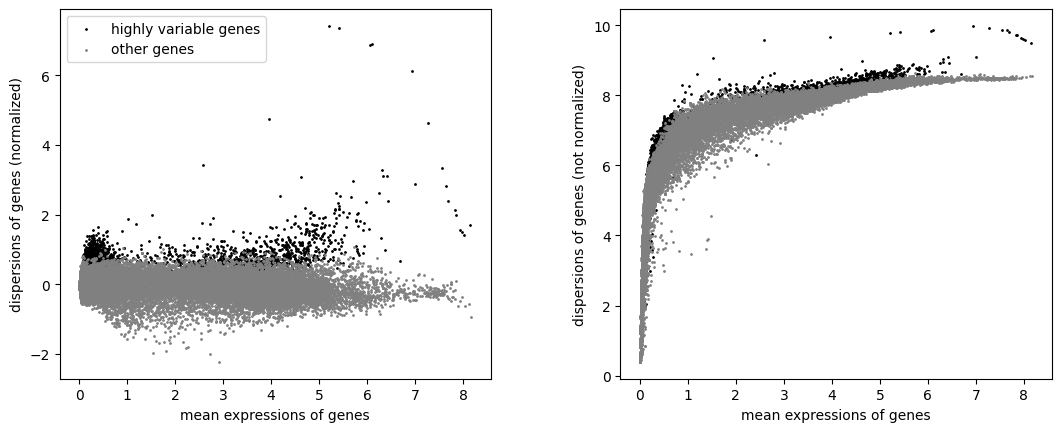

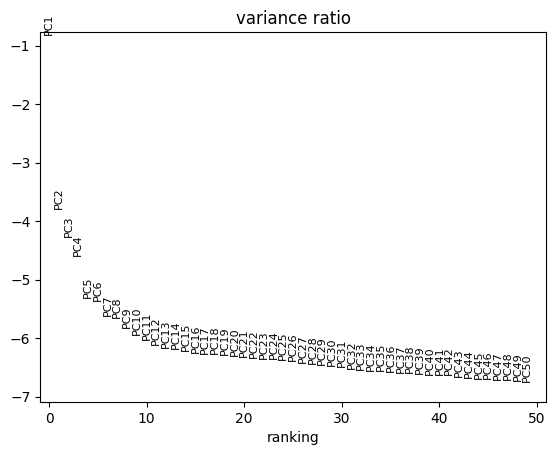

In [101]:
# Saving raw count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e+06)

# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample") # flavor='seurat_v3')

sc.pl.highly_variable_genes(adata)

sc.tl.pca(adata) #  n_comps=50, svd_solver='arpack'
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

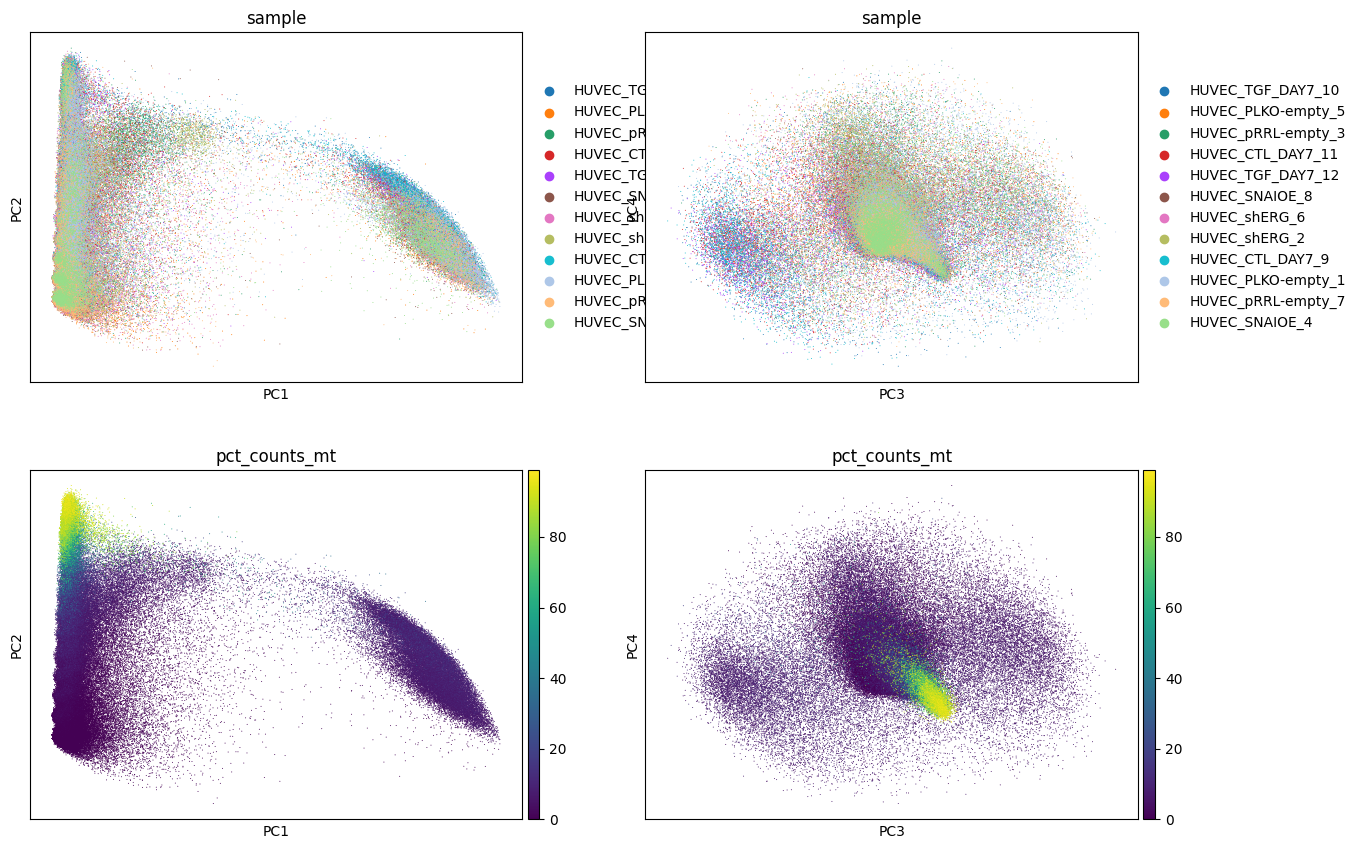

In [102]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [104]:
resolutions = np.arange(0.1, 1.1, 0.5)
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
for r in resolutions:
    sc.tl.leiden(adata, 
                 resolution=r, 
                 key_added=f'leiden_{r:.1f}', flavor="igraph")

In [ ]:
## Louvain
for r in resolutions:
    sc.tl.leiden(adata, 
                 resolution=r, 
                 key_added=f'louvain_{r:.1f}')

In [ ]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="sample", # or ["column1", "column2", "column3"]
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [117]:
sc.external.pp.harmony_integrate(adata, key='sample', 
                                 basis='X_pca', 
                                 adjusted_basis='X_harmony', 
                                 max_iter_harmony = 100)

2025-08-28 17:09:39,013 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-28 17:09:49,757 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-28 17:09:50,471 - harmonypy - INFO - Iteration 1 of 100
2025-08-28 17:11:08,062 - harmonypy - INFO - Iteration 2 of 100
2025-08-28 17:12:31,515 - harmonypy - INFO - Iteration 3 of 100
2025-08-28 17:13:52,659 - harmonypy - INFO - Iteration 4 of 100
2025-08-28 17:15:14,143 - harmonypy - INFO - Iteration 5 of 100
2025-08-28 17:16:28,019 - harmonypy - INFO - Iteration 6 of 100
2025-08-28 17:17:41,278 - harmonypy - INFO - Iteration 7 of 100
2025-08-28 17:18:56,166 - harmonypy - INFO - Iteration 8 of 100
2025-08-28 17:20:02,238 - harmonypy - INFO - Iteration 9 of 100
2025-08-28 17:20:29,755 - harmonypy - INFO - Iteration 10 of 100
2025-08-28 17:20:55,468 - harmonypy - INFO - Iteration 11 of 100
2025-08-28 17:21:19,571 - harmonypy - INFO - Iteration 12 of 100
2025-08-28 17:21:45,232 - harmonypy - INFO - Ite

In [118]:
var2int = 'sample'

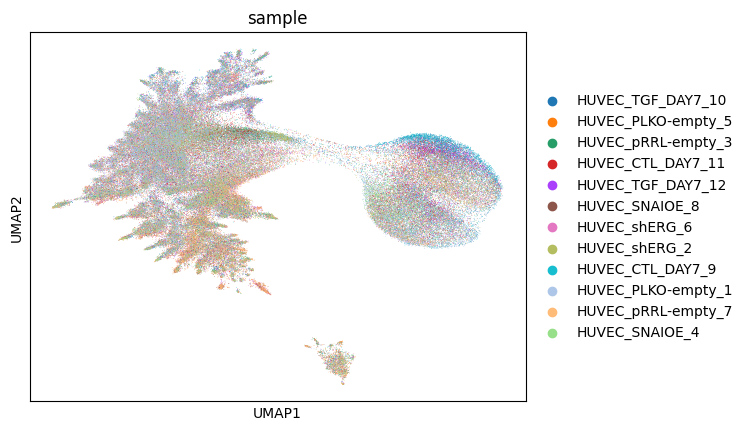

In [125]:
# BBKNN
sc.external.pp.bbknn(adata, 
                     batch_key=var2int, 
                     copy=True)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["sample"])

In [126]:
sc.external.pp.mnn_correct(adata, batch_key = var2int)

((AnnData object with n_obs × n_vars = 143656 × 23676
      obs: 'sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2', 'louvain_0.3', 'louvain_0.4', 'louvain_0.5', 'louvain_0.6', 'louvain_0.7', 'louvain_0.8', 'louvain_0.9', 'louvain_1.0'
      var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louva

In [130]:
sc.external.pp.scanorama_integrate(adata, key = var2int)

[[0.         0.22007168 0.42547688 0.44019283 0.33232901 0.19775033
  0.21924274 0.35894346 0.63869959 0.53017977 0.16601386 0.24140541]
 [0.         0.         0.33648746 0.3502509  0.30322581 0.68157706
  0.60143369 0.24630824 0.12874552 0.28057348 0.69820789 0.17921147]
 [0.         0.         0.         0.35240866 0.21166074 0.25897187
  0.27265869 0.53012178 0.32007597 0.64694471 0.22405432 0.31513514]
 [0.         0.         0.         0.         0.76963641 0.38479137
  0.35146159 0.32149093 0.33404089 0.37036052 0.33364606 0.27124324]
 [0.         0.         0.         0.         0.         0.37988888
  0.34304746 0.27171801 0.31069154 0.349246   0.30695096 0.24248649]
 [0.         0.         0.         0.         0.         0.
  0.64222682 0.30079529 0.19394481 0.32999237 0.60638414 0.272     ]
 [0.         0.         0.         0.         0.         0.
  0.         0.48451005 0.24131382 0.38370399 0.60733475 0.27416216]
 [0.         0.         0.         0.         0.         

In [131]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2', 'louvain_0.3', 'louvain_0.4', 'louvain_0.5', 'louvain_0.6', 'louvain_0.7', 'louvain_0.8', 'louvain_0.9', 'louvain_1.0'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2',

In [135]:
sc.pp.neighbors(adata, use_rep='X_scanorama')

In [136]:
sc.tl.umap(adata)

/home/mhassan/miniconda3/envs/scIB/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mhassan/miniconda3/envs/scIB/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


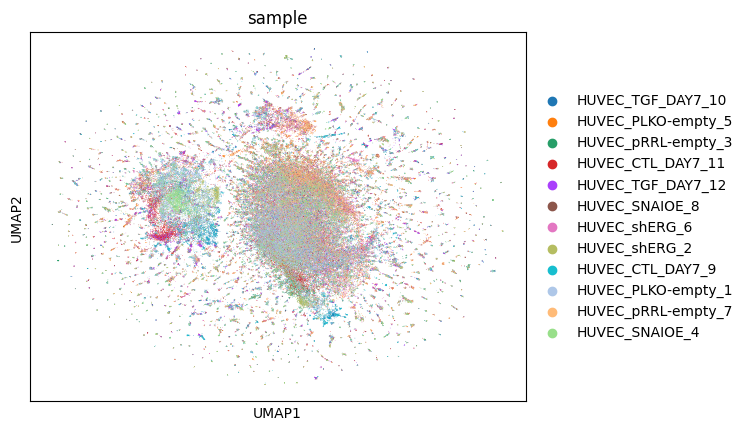

In [137]:
sc.pl.umap(adata, color = 'sample')

In [139]:
# Find marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_0.1', 
                        method='wilcoxon', 
                        min_in_group_fraction=0.15, 
                        logfc_min=0.3)

/home/mhassan/miniconda3/envs/scIB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/mhassan/miniconda3/envs/scIB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/mhassan/miniconda3/envs/scIB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:440: Perform

In [140]:
# Get the top 50 and 100 marker genes per cluster
markers_df = sc.get.rank_genes_groups_df(adata, group=None)
markers_df.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,EEF1A1,151.912842,2.216327,0.0,0.0
1,0,TMSB4X,138.473862,1.882623,0.0,0.0
2,0,RPLP1,121.363472,1.487533,0.0,0.0
3,0,FTL,107.394043,1.167412,0.0,0.0
4,0,RPS2,104.551369,1.108089,0.0,0.0


In [193]:
markers_df.to_excel('/home/mhassan/markers.xlsx')

In [144]:
# Extracting top n genes
n = 30
markers_df.loc[markers_df["group"] == '0', "names"].head(n)

0     EEF1A1
1     TMSB4X
2      RPLP1
3        FTL
4       RPS2
5        VIM
6       FTH1
7       ACTB
8      RPS19
9     MT-CO2
10     RPS28
11    S100A6
12      TPT1
13     RPS12
14    TMSB10
15     RPL10
16     RPS18
17      MT2A
18     RPL41
19     ACTG1
20      RPS8
21      PTMA
22     RPL39
23     RPL28
24     RPL7A
25    LGALS1
26      RPS3
27     RPL29
28     RPS14
29     RPL12
Name: names, dtype: object

In [145]:
# Top 50 genes per cluster
top50 = markers_df.groupby('group').apply(lambda x: x.nlargest(50, 'logfoldchanges')).reset_index(drop=True)
top50

/tmp/ipykernel_1125511/1081260115.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top50 = markers_df.groupby('group').apply(lambda x: x.nlargest(50, 'logfoldchanges')).reset_index(drop=True)
/tmp/ipykernel_1125511/1081260115.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top50 = markers_df.groupby('group').apply(lambda x: x.nlargest(50, 'logfoldchanges')).reset_index(drop=True)


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,EEF1A1,151.912842,2.216327,0.000000e+00,0.000000e+00
1,0,TMSB4X,138.473862,1.882623,0.000000e+00,0.000000e+00
2,0,RPLP1,121.363472,1.487533,0.000000e+00,0.000000e+00
3,0,MT-CO2,88.551895,1.308942,0.000000e+00,0.000000e+00
4,0,FTL,107.394043,1.167412,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
1095,21,RPS3,12.920116,1.546854,3.466145e-38,1.519712e-35
1096,21,EEF1A1,15.084972,1.530077,2.033608e-51,1.719561e-48
1097,21,AL451042.2,0.032334,1.522749,9.742056e-01,9.993350e-01
1098,21,RPS6,12.284324,1.502000,1.099606e-34,4.267912e-32


In [161]:
# Reading Excel file
ECs_markers = pd.read_excel("/home/mhassan/Files/Vascular_markers_summary.xlsx", sheet_name=0)
ECs_markers

# Drop unwanted notes and NaNs
ECs_markers = ECs_markers.replace(r"\s*\(.*?\)", 
                                  "", 
                                  regex=True).dropna(how="all")

In [162]:
ECs_markers

,Venous ECs,Arterial ECs,Capillary ECs,Pericytes,VSMCs,Lymphatic ECs,SubECs
0,IL1R1,PCSK5,CADM2,COL25A1,MYH11,PKHD1L1,NEGR1
1,SELP,NEBL,BTNL9,STEAP4,ACTA2,MMRN1,MRC1
2,LIFR,FN1,CEACAM1,NCKAP5,TAGLN,CCL21,DCLK1
3,ACKR1,EFNB2,CDH13,INPP4B,CARMN,RELN,KAZN
4,VCAN,GJA5,PPARG,ABCC9,RYR2,MPP7,DCN
5,NaN,FBLN5,CD36,RGS5,KCNAB1,PROX1,F13A1
6,NaN,NaN,CA4,PDGFRB,MYL9,TFPI,SVEP1
7,NaN,NaN,LPL,IGFBP5,CACNA1C,FLT4,FMN1
8,NaN,NaN,LIPE,RGS6,LMOD1,PDPN,COLEC12
9,NaN,NaN,RBP7,NOTCH3,MYOM1,LYVE1,CFD


In [188]:
ECs_markers.columns = ECs_markers.columns.str.replace('\\s', '_', regex=True)

In [189]:
# Convert to dictionary of gene lists
gene_sets = {col: ECs_markers[col].dropna().tolist() for col in ECs_markers.columns}

In [190]:
gene_sets

{'Venous_ECs': ['IL1R1', 'SELP', 'LIFR', 'ACKR1', 'VCAN'],
 'Arterial_ECs': ['PCSK5', 'NEBL', 'FN1', 'EFNB2', 'GJA5', 'FBLN5'],
 'Capillary_ECs': ['CADM2',
  'BTNL9',
  'CEACAM1',
  'CDH13',
  'PPARG',
  'CD36',
  'CA4',
  'LPL',
  'LIPE',
  'RBP7',
  'RGCC',
  'FABP4',
  'PLVAP'],
 'Pericytes': ['COL25A1',
  'STEAP4',
  'NCKAP5',
  'INPP4B',
  'ABCC9',
  'RGS5',
  'PDGFRB',
  'IGFBP5',
  'RGS6',
  'NOTCH3',
  'ENPEP',
  'KCNJ8',
  'CSPG4'],
 'VSMCs': ['MYH11',
  'ACTA2',
  'TAGLN',
  'CARMN',
  'RYR2',
  'KCNAB1',
  'MYL9',
  'CACNA1C',
  'LMOD1',
  'MYOM1',
  'MYOCD'],
 'Lymphatic_ECs': ['PKHD1L1',
  'MMRN1',
  'CCL21',
  'RELN',
  'MPP7',
  'PROX1',
  'TFPI',
  'FLT4',
  'PDPN',
  'LYVE1'],
 'SubECs': ['NEGR1',
  'MRC1',
  'DCLK1',
  'KAZN',
  'DCN',
  'F13A1',
  'SVEP1',
  'FMN1',
  'COLEC12',
  'CFD',
  'PTPRC',
  'RBPJ',
  'CXCL14',
  'MSR1',
  'CD163',
  'PDE3B',
  'ADH1B',
  'MS4A4A',
  'CD44',
  'PDGFRA',
  'WDPCP',
  'MFAP5',
  'TRHDE',
  'GHR',
  'MGP']}

In [191]:
for name, genes in gene_sets.items():
    sc.tl.score_genes(
        adata, 
        gene_list=genes, 
        score_name=f"{name}_signature"
    )

In [177]:
adata.obs = adata.obs.drop(columns = ['Venous ECs_signature', 'Arterial ECs_signature', 'Capillary ECs_signature', 'Pericytes_signature', 'VSMCs_signature', 'Lymphatic ECs_signature', 'SubECs_signature'])

In [178]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2', 'louvain_0.3', 'louvain_0.4', 'louvain_0.5', 'louvain_0.6', 'louvain_0.7', 'louvain_0.8', 'louvain_0.9', 'louvain_1.0'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2',

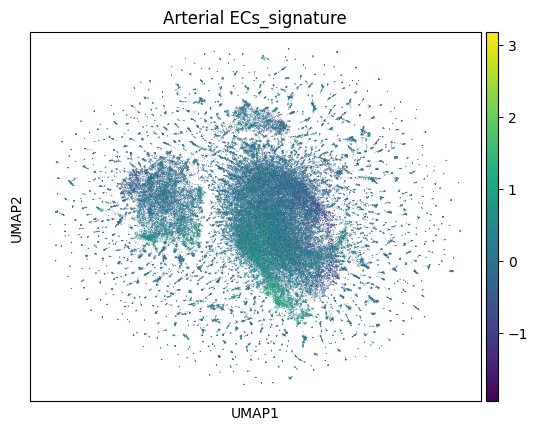

In [153]:
sc.pl.umap(adata, color=['Arterial ECs_signature'])

In [123]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2', 'louvain_0.3', 'louvain_0.4', 'louvain_0.5', 'louvain_0.6', 'louvain_0.7', 'louvain_0.8', 'louvain_0.9', 'louvain_1.0'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2',

In [ ]:
# MNN
sc.external.pp.mnn_correct(adata, batch_key = var2int)

In [ ]:
# Scanorama
scanpy.external.pp.scanorama_integrate(adata, key = var2int)

In [ ]:
# Find marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_0.3', method='wilcoxon', min_in_group_fraction=0.15, logfc_min=0.3)

# Get the top 50 and 100 marker genes per cluster
markers_df = sc.get.rank_genes_groups_df(adata, group=None)

# Top 50 genes per cluster
top50 = markers_df.groupby('group').apply(lambda x: x.nlargest(50, 'logfoldchanges')).reset_index(drop=True)

In [194]:
# Define new names for clusters
new_names = {
    '0': 'clus0', 
    '1': 'clus1', 
    '2': 'clus2', 
    '3': 'clus3',
    '4': 'clus4',
    '5': 'clus5',
    '6': 'clus6'}

# Recode identities
adata.obs['annotation'] = adata.obs['leiden_0.3'].replace(new_names)

/tmp/ipykernel_1125511/2685940737.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['annotation'] = adata.obs['leiden_0.3'].replace(new_names)


In [195]:
adata.obs

,sample,n_counts,n_genes_by_counts,pct_counts_mt,Condition,day,BMI,combined,group,trt,...,louvain_0.9,louvain_1.0,Venous_ECs_signature,Arterial_ECs_signature,Capillary_ECs_signature,Pericytes_signature,VSMCs_signature,Lymphatic_ECs_signature,SubECs_signature,annotation
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,10.679611,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,...,6,7,0.000000,-0.148863,-0.018608,-0.041351,-0.026583,-0.093664,0.000000,clus1
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,68.840584,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,...,7,6,-0.039365,-0.118174,0.000000,-0.065704,0.000000,-0.033050,-0.026278,clus4
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.934813,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,...,7,6,-0.061140,-0.428597,-0.152873,-0.322802,-0.021836,-0.230936,-0.091848,clus4
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,75.634514,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,...,7,6,0.000000,-0.078111,0.000000,-0.108416,-0.027861,-0.032722,0.000000,clus4
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,4.876396,TGF,7,40,HUVEC_TGF_DAY7_10_TGF,normal,TGF,...,2,1,0.583755,0.187941,-0.402473,-0.466130,-0.499045,0.224626,-0.327959,clus2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HUVEC_SNAIOE_4_TTTGTTGCAGTCTTCC-1,HUVEC_SNAIOE_4,49833.0,7810,4.192086,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,...,2,1,-0.527590,-0.612995,-0.025857,-0.144474,0.608344,0.892124,-0.792682,clus2
HUVEC_SNAIOE_4_TTTGTTGGTGAATTAG-1,HUVEC_SNAIOE_4,23288.0,5475,5.582514,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,...,2,1,-0.976947,-0.137646,-0.923262,0.056236,-0.504340,0.147359,-0.431013,clus2
HUVEC_SNAIOE_4_TTTGTTGGTTGCCATA-1,HUVEC_SNAIOE_4,25746.0,5604,5.313653,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,...,2,1,-1.054073,-1.045130,-0.073282,-0.305766,0.106201,0.086418,0.011288,clus2
HUVEC_SNAIOE_4_TTTGTTGTCGCCGAAC-1,HUVEC_SNAIOE_4,905.0,537,0.220994,HUVEC_SNAIOE_4,HUVEC_SNAIOE_4,40,HUVEC_SNAIOE_4_HUVEC_SNAIOE_4,normal,SNAIOE,...,3,3,-0.030100,-0.662807,-0.135451,0.277511,-0.043000,-0.480201,-0.050251,clus0


In [200]:
chosen_res = 'louvain_0.9'
clusters = '6'
# Subset data to subset cluster 
adata = adata[adata.obs[chosen_res] != clusters].copy()
adata

AnnData object with n_obs × n_vars = 0 × 23676
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'Condition', 'day', 'BMI', 'combined', 'group', 'trt', 'dayofexp', 'replicate', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'louvain_0.1', 'louvain_0.2', 'louvain_0.3', 'louvain_0.4', 'louvain_0.5', 'louvain_0.6', 'louvain_0.7', 'louvain_0.8', 'louvain_0.9', 'louvain_1.0', 'Venous_ECs_signature', 'Arterial_ECs_signature', 'Capillary_ECs_signature', 'Pericytes_signature', 'VSMCs_signature', 'Lymphatic_ECs_signature', 'SubECs_signature', 'annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'u

In [25]:
### Adding mito and ribo percentage
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [26]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], 
    inplace=True, log1p=True
)

In [27]:
adata

AnnData object with n_obs × n_vars = 143656 × 23676
    obs: 'sample', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [38]:
adata.obsm.keys()

KeysView(AxisArrays with keys: )

In [34]:
adata.shape[0]

143656

In [28]:
adata.obs.head()

,sample,n_counts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1,HUVEC_TGF_DAY7_10,103.0,91,4.521789,103.0,4.644391,60.194175,100.000000,100.000000,100.000000,11.0,2.484907,10.679611,15.0,2.772589,14.563107
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1,HUVEC_TGF_DAY7_10,138.0,53,3.988984,138.0,4.934474,97.826087,100.000000,100.000000,100.000000,95.0,4.564348,68.840584,10.0,2.397895,7.246377
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1,HUVEC_TGF_DAY7_10,721.0,478,6.171701,721.0,6.582025,32.593620,46.740638,61.442441,100.000000,50.0,3.931826,6.934813,166.0,5.117994,23.023579
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1,HUVEC_TGF_DAY7_10,197.0,58,4.077537,197.0,5.288267,95.939086,100.000000,100.000000,100.000000,149.0,5.010635,75.634514,7.0,2.079442,3.553300
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1,HUVEC_TGF_DAY7_10,51658.0,7970,8.983565,51657.0,10.852401,21.288499,30.648315,40.048783,52.771164,2519.0,7.832014,4.876396,9020.0,9.107310,17.461330


In [29]:
# Split 'sample' column
split_cols = adata.obs['sample'].str.split('_', expand=True)

adata.obs[['condition', 'day', 'replicate']] = split_cols[[1, 2, 3]]

print(adata.obs.head())

                                                 sample  n_counts  \
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1  HUVEC_TGF_DAY7_10     103.0   
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1  HUVEC_TGF_DAY7_10     138.0   
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1  HUVEC_TGF_DAY7_10     721.0   
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1  HUVEC_TGF_DAY7_10     197.0   
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1  HUVEC_TGF_DAY7_10   51658.0   

                                      n_genes_by_counts  \
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1                 91   
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1                 53   
HUVEC_TGF_DAY7_10_AAACCCAAGTTTGAGA-1                478   
HUVEC_TGF_DAY7_10_AAACCCACAGATACTC-1                 58   
HUVEC_TGF_DAY7_10_AAACCCACAGGATGAC-1               7970   

                                      log1p_n_genes_by_counts  total_counts  \
HUVEC_TGF_DAY7_10_AAACCCAAGGAGCAAA-1                 4.521789         103.0   
HUVEC_TGF_DAY7_10_AAACCCAAGTCTGGTT-1                 3.988984         13

### Quality check

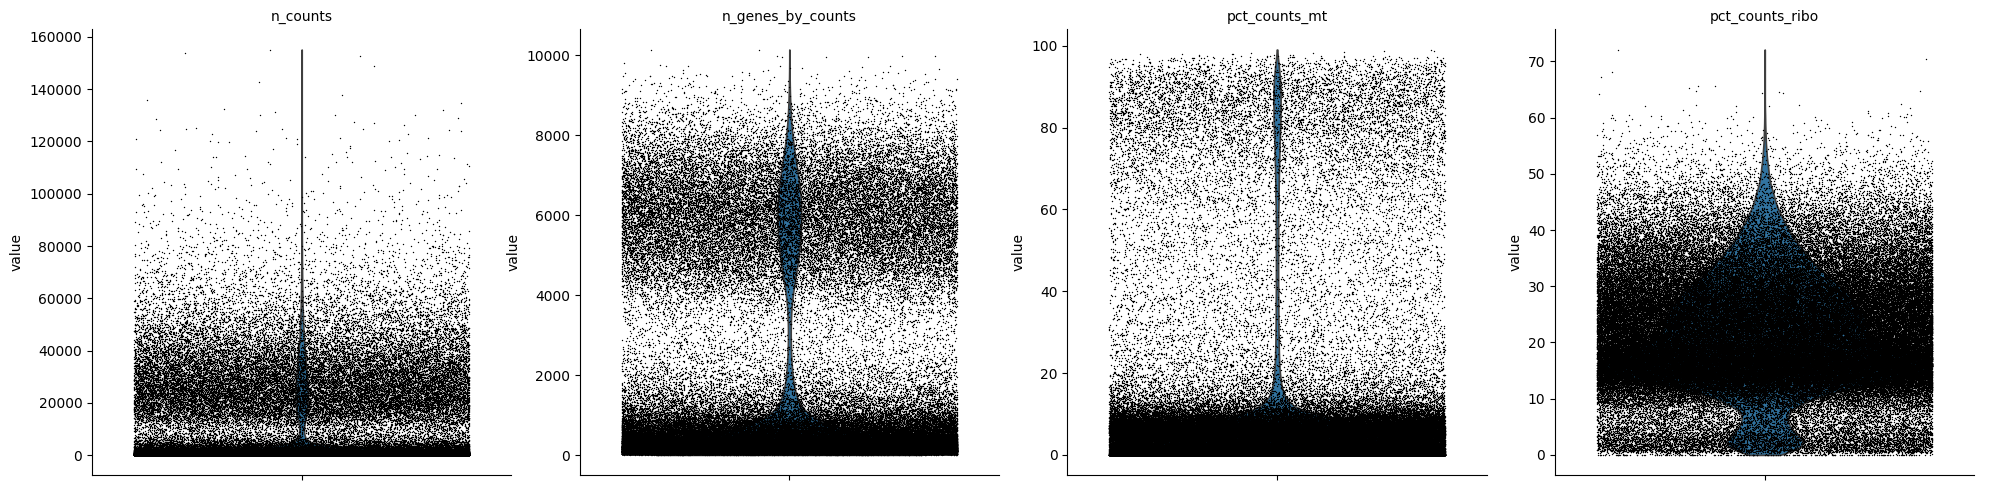

In [30]:
sc.pl.violin(adata, ['n_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
                 jitter=0.4, multi_panel=True)

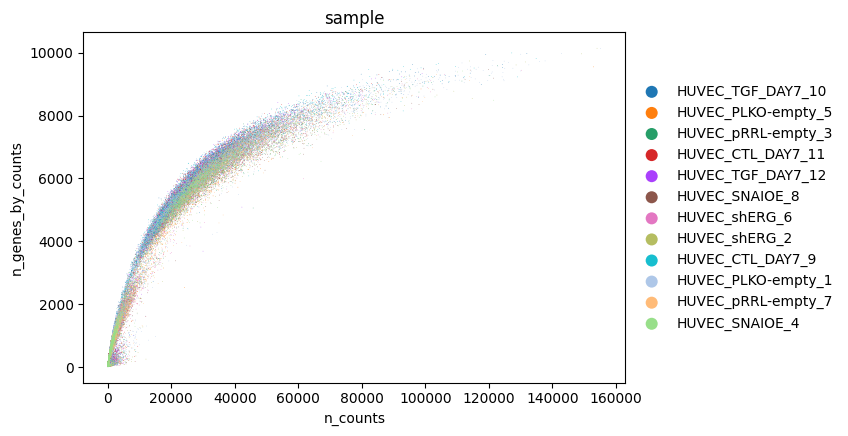

In [31]:
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color='sample')

In [32]:
# Create a dictionary to store each AnnData object with its filename as the key
adata_obj = {file: adata for file, adata in zip(files, adata_list)}

### Removing cells using lm

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Get log-transformed nFeature_RNA and nCount_RNA
log_nFeature_RNA = np.log(HFD_Epi_A.obs['n_genes'])
log_nCount_RNA = np.log(HFD_Epi_A.obs['n_counts'])

# Fit a linear model using statsmodels
X = sm.add_constant(log_nCount_RNA)  # Adds an intercept to the model
model = sm.OLS(log_nFeature_RNA, X).fit()

# Get residuals
residuals = model.resid

# Filter cells with residuals >= -0.5
tokeep = residuals[residuals >= -0.5].index
HFD_Epi_A = HFD_Epi_A[tokeep, :]

# Plotting
plt.scatter(log_nCount_RNA, log_nFeature_RNA, c='grey', label='All cells', s=10)
plt.plot(log_nCount_RNA, model.fittedvalues, color='red', linewidth=3, label='Linear fit')
plt.scatter(log_nCount_RNA.loc[tokeep], log_nFeature_RNA.loc[tokeep], c='blue', label='Filtered cells', s=20)
plt.xlabel('log(nCount_RNA)')
plt.ylabel('log(nFeature_RNA)')
plt.legend()
plt.show()

### Merging samples

In [ ]:
import scanpy as sc
import pandas as pd

# Merge multiple AnnData objects
Merged_raw_object = HFD_Epi_A.concatenate(HFD_Epi_B, HFD_Mes_A, HFD_Mes_B, 
                                          NC_Epi_A, NC_Epi_B, NC_Mes_A, NC_Mes_B, 
                                          index_unique=None)  # Don't append object names to index

# Display merged object
print(Merged_raw_object)

### Saving merged objecct

In [ ]:
# Save the updated AnnData object if needed
adata.write('adata.h5ad')

### Adding metadata info

In [ ]:
# Convert .obs to a pandas DataFrame
df_Merged_raw_object = Merged_raw_object.obs.copy()

# Select relevant columns (assuming Mt_Rb is present)
df_Merged_raw_object = df_Merged_raw_object[['orig.ident', 'n_counts', 'n_genes', 'percent_mito', 'Mt_Rb']]

# Add "Condition" column based on "orig.ident"
df_Merged_raw_object['Condition'] = df_Merged_raw_object['orig.ident']

# Replace Condition values based on orig.ident
df_Merged_raw_object['Condition'] = df_Merged_raw_object['Condition'].replace(
    {'NC_Epi_A': 'NC', 'NC_Epi_B': 'NC', 'NC_Mes_A': 'NC', 'NC_Mes_B': 'NC', 
     'HFD_Epi_A': 'HFD', 'HFD_Epi_B': 'HFD', 'HFD_Mes_A': 'HFD', 'HFD_Mes_B': 'HFD'})

# Add "Depot" column based on "orig.ident"
df_Merged_raw_object['Depot'] = df_Merged_raw_object['orig.ident']

# Replace Depot values based on orig.ident
df_Merged_raw_object['Depot'] = df_Merged_raw_object['Depot'].replace(
    {'NC_Epi_A': 'Epi', 'NC_Epi_B': 'Epi', 'HFD_Epi_A': 'Epi', 'HFD_Epi_B': 'Epi',
     'NC_Mes_A': 'Mes', 'NC_Mes_B': 'Mes', 'HFD_Mes_A': 'Mes', 'HFD_Mes_B': 'Mes'})

# Show updated DataFrame
df_Merged_raw_object.head()

In [ ]:
# Assuming df_In_House is a DataFrame in Python
df_In_House['BMI'] = df_In_House['orig.ident']

# Update BMI based on the presence of 'SAT9' in the 'orig.ident' column
df_In_House['BMI'] = df_In_House['BMI'].replace(to_replace=r'SAT9', value='39.5', regex=True)

# Show updated df_In_House
df_In_House.head()

### Adding a column from existing columns

In [ ]:
# Concatenate 'Study' and 'Chemistry' columns to create 'Study_chemistry'
All_Data_Atlas['Study_chemistry'] = All_Data_Atlas['Study'] + '_' + All_Data_Atlas['Chemistry']

# Display the updated DataFrame
print(All_Data_Atlas)

# Change a column into categorical

In [ ]:
adata.obs['louvain'] = adata.obs['louvain'].astype('category')

# Show categories (factor levels)

In [ ]:
print(adata.obs['louvain'].cat.categories)

## drop levels

In [ ]:
### One column
adata.obs['louvain'] = adata.obs['louvain'].cat.remove_unused_categories()

In [ ]:
### Multiple columns
for col in adata.obs.select_dtypes(['category']).columns:
    adata.obs[col] = adata.obs[col].cat.remove_unused_categories()

### Adding cell cycle info

In [ ]:
import pandas as pd
import requests

# URL of the cell cycle gene list
url = "https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Homo_sapiens.csv"

# Download the file and read into a DataFrame
response = requests.get(url)
cell_cycle_genes = pd.read_csv(pd.compat.StringIO(response.text))

# Display the first few rows of the DataFrame
print(cell_cycle_genes.head())


from biomart import BiomartServer

# Connect to Biomart server
server = BiomartServer('http://www.ensembl.org/biomart')
mart = server.datasets['hsapiens_gene_ensembl']

# Get gene annotations
attributes = [
    'ensembl_gene_id', 'external_gene_name', 'chromosome_name', 
    'gene_biotype', 'description'
]
annotations = mart.query(attributes=attributes)
annotations = annotations.to_dataframe()

# Display the first few rows
print(annotations.head())


# Merge cell cycle genes with annotations
cell_cycle_markers = pd.merge(cell_cycle_genes, annotations, left_on='geneID', right_on='ensembl_gene_id')

# Get S phase genes
s_genes = cell_cycle_markers[cell_cycle_markers['phase'] == 'S']['external_gene_name'].tolist()

# Get G2M phase genes
g2m_genes = cell_cycle_markers[cell_cycle_markers['phase'] == 'G2/M']['external_gene_name'].tolist()


# Perform cell cycle scoring
sc.tl.score_genes(adata, gene_list=s_genes, score_name='S_score')
sc.tl.score_genes(adata, gene_list=g2m_genes, score_name='G2M_score')

# Display the first few rows of the updated metadata
print(adata.obs.head())



## Data Analysis

In [ ]:
# Visualizing the expression of specific features
sc.pl.umap(adata, color=['ncount', 'ngenes'])  # Assuming 'nCount_RNA' and 'nFeature_RNA' are present

### Data Normalization

In [ ]:
# Log-normalizing the data (similar to LogNormalize in Seurat)
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

### Highly variable genes

In [ ]:
# Finding highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

### Scaling

In [ ]:
# Scaling the data
sc.pp.scale(adata)  # You can also add options like `max_value`

## Regressing out variables


### PCA

In [ ]:
# Running PCA
sc.tl.pca(adata, svd_solver='arpack')

#### Elbow plot

In [ ]:
# Elbow plot
sc.pl.pca_variance_ratio(adata, log=True)

#### Significant PCs

In [ ]:
# Get the explained variance ratio for each PC
pct = adata.uns['pca']['variance_ratio'] * 100
cum = pct.cumsum()
co1 = (cum > 90).argmax() + 1  # First component where cumulative variance exceeds 90%
co2 = (pct[1:] - pct[:-1] > 0.05).nonzero()[0].max() + 2
pcs = min(co1, co2)
sig_pcs = list(range(1, pcs+1))  # Significant PCs
print(sig_pcs)

### Finding neighbors

In [ ]:
# Find neighbors using significant PCs
sc.pp.neighbors(adata, n_pcs=pcs)

### UMAP construction

In [ ]:
# Run UMAP
sc.tl.umap(adata)
sc.pl.umap(adata)  # Plot UMAP

In [ ]:
# Data Integration using harmony

In [ ]:
import harmonypy as hm

# Assuming 'adata' is the AnnData object and 'orig.ident' is stored in 'adata.obs'
harmony_integrator = hm.HarmonyIntegrator(X=adata.obsm['X_pca'], meta_data=adata.obs['orig.ident'])
harmony_integrator.run()

# Add harmony embedding to the AnnData object
adata.obsm['X_harmony'] = harmony_integrator.Z_corr.T

#### Significant harmony components

In [ ]:
# Get the explained variance ratio of Harmony components
pct = harmony_integrator.vars_ / harmony_integrator.vars_.sum() * 100
cum = pct.cumsum()
co1 = (cum > 90).argmax() + 1
co2 = (pct[1:] - pct[:-1] > 0.05).nonzero()[0].max() + 2
pcs = min(co1, co2)
harmony_sig_pcs = list(range(1, pcs + 1))
print(harmony_sig_pcs)

In [ ]:
# Running UMAP using the Harmony dimensions
sc.pp.neighbors(adata, use_rep='X_harmony', n_pcs=pcs)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['orig.ident'], legend_loc='on data')  # You can label points if needed

In [ ]:
### Gene Signatures

In [ ]:
# Reading Excel file
ECs_markers_ref = pd.read_excel("/home/lucamannino/Downloads/Vascular_markers_summary.xlsx", sheet_name=0)

# Splitting 'Capillary.ECs' column into two
ECs_markers_ref[['Capillary.ECs', '_']] = ECs_markers_ref['Capillary.ECs'].str.split(' ', expand=True)
ECs_markers_ref.drop(columns='_', inplace=True)

# Removing NaN values
ECs_markers_ref_cleaned = {col: ECs_markers_ref[col].dropna().tolist() for col in ECs_markers_ref.columns}

In [ ]:
## Adding signature
from itertools import chain

for cell_type, gene_list in ECs_markers_ref_cleaned.items():
    # Compute the module score for each cell type
    sc.tl.score_genes(adata, gene_list, score_name=f'{cell_type}_signature')

# Rename columns to match the Seurat format if needed
adata.obs.columns = adata.obs.columns.str.replace('_signature1$', '_signature')

In [ ]:
## Extract signature columns

# Extract columns with '_signature' in their names
signature_columns = [col for col in adata.obs.columns if col.endswith('_signature')]

In [ ]:
import matplotlib.pyplot as plt

# Plot the feature expression of each signature column
sc.pl.umap(adata, color=signature_columns, ncols=3, cmap='viridis')

In [ ]:
### Clustering

In [ ]:
resolutions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Perform clustering for different resolutions
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')

In [ ]:
# Visualize clusters identified by the Leiden algorithm across different resolutions
snn_columns = [col for col in adata.obs.columns if col.startswith('leiden')]
sc.pl.umap(adata, color=snn_columns, ncols=5)

In [ ]:
# Set identity based on a specific resolution (e.g., res=0.3)
adata.obs['leiden_0.3'] = adata.obs['leiden_0.3'].astype('category')
adata.obs['leiden_0.3'].cat.categories

### Finding marker genes

In [ ]:
# Find marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_0.3', method='wilcoxon', min_in_group_fraction=0.15, logfc_min=0.3)

# Get the top 50 and 100 marker genes per cluster
markers_df = sc.get.rank_genes_groups_df(adata, group=None)

# Top 50 genes per cluster
top50 = markers_df.groupby('group').apply(lambda x: x.nlargest(50, 'logfoldchanges')).reset_index(drop=True)

# Top 100 genes per cluster
top100 = markers_df.groupby('group').apply(lambda x: x.nlargest(100, 'logfoldchanges')).reset_index(drop=True)

### Exporting marker gene list

In [ ]:
import pandas as pd

# Save as Excel
markers_df.to_excel("markers_Vascular_WRST_15PCT_Log03_res02.xlsx", index=True)

### Cluster annotation

In [ ]:
# Define new names for clusters
new_names = {
    '0': '', 
    '1': '', 
    '2': '', 
    '3': '',
    '4': '',
    '5': '',
    '6': ''}

# Recode identities
adata_subset.obs['WAT_Vascular_labels'] = adata_subset.obs['leiden_0.3'].replace(new_names)

### Cluster subset (exact)

In [ ]:
# Subset data to subset cluster '11'
adata_subset = adata[adata.obs['leiden_0.3'] == '11'].copy()

### Cluster subset (inclusion)

In [ ]:
vascular_cells = adata[adata.obs['RNA_snn_res.0.5'].isin(['4', '6', '7', '11', '12', '13', '14', '24', '27'])]
vascular_cells

### Cluster subset (exclusion)

In [ ]:
# Subset data to exclude cluster '11'
adata_subset = adata[adata.obs['leiden_0.3'] != '11'].copy()

## Saving all objects in the environment

In [ ]:
import pickle
import sys

# Get all objects in the global namespace
all_objects = {name: obj for name, obj in globals().items() if not name.startswith('__') and not callable(obj)}

# Save all objects to a file
with open('my_workspace.pkl', 'wb') as file:
    pickle.dump(all_objects, file)


In [ ]:
import pickle
import types

def is_pickleable(obj):
    """Check if an object can be pickled."""
    try:
        pickle.dumps(obj)
    except (pickle.PicklingError, TypeError, AttributeError):
        return False
    return True

def is_global(obj_name, obj):
    """Check if an object is globally accessible and not a local function or method."""
    return isinstance(obj, (types.ModuleType, types.FunctionType)) is False and not obj_name.startswith('__')

# Get all pickleable and globally accessible objects in the global namespace
pickleable_objects = {
    name: obj for name, obj in globals().items()
    if is_global(name, obj) and is_pickleable(obj)
}

# Save pickleable objects to a file
with open('workspace.pkl', 'wb') as file:
    pickle.dump(pickleable_objects, file)

## Loading an environment

In [ ]:
import pickle

# Load all objects from a file
with open('my_workspace.pkl', 'rb') as file:
    loaded_objects = pickle.load(file)

# Restore all objects to the global namespace
globals().update(loaded_objects)

# Verify objects are loaded
print(loaded_objects)